# Script that perform modelling using different models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

In [2]:
sparse_matrix = pd.read_csv('matrix.csv')

In [21]:
X = sparse_matrix.iloc[:,0:-1]
Y = sparse_matrix.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Näive Bayes

In [22]:
# Naive Bayes
nb = GaussianNB()
                                                    
nb.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_nb = accuracy_score(Y_test, y_pred)
recall_nb = recall_score(Y_test, y_pred, average='micro')
f1_score_nb = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", round(accuracy_nb, 5))
print("Recall:", recall_nb)
print("F1 Score:", f1_score_nb)

Accuracy: 0.53922
Recall: 0.5392156862745098
F1 Score: 0.5392156862745098


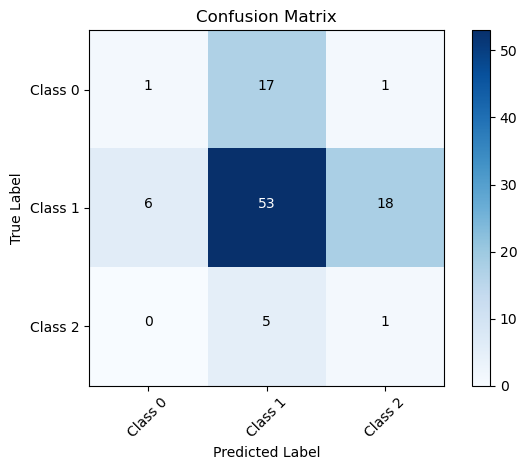

In [23]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels to matrix cells
classes = ['Class 0', 'Class 1', 'Class 2']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add numerical values inside the matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Multinomial Bayes

In [24]:
fb = MultinomialNB()

fb.fit(X_train, Y_train)

# Step 5: Make predictions on the test set
y_pred = fb.predict(X_test)

# Step 6: Evaluate the performance of the classifier
accuracy_fb = accuracy_score(Y_test, y_pred)
recall_fb = recall_score(Y_test, y_pred, average='micro')
f1_score_fb = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", round(accuracy_fb, 5))
print("Recall:", recall_fb)
print("F1 Score:", f1_score_fb)

Accuracy: 0.7549
Recall: 0.7549019607843137
F1 Score: 0.7549019607843137


### Decision Tree

In [25]:
# Decision Tree
dt = DecisionTreeClassifier(criterion='entropy', random_state=42, splitter='best')

# Train the classifier
dt.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_dt = accuracy_score(Y_test, y_pred)
recall_dt = recall_score(Y_test, y_pred, average='micro')
f1_score_dt = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", round(accuracy_dt, 5))
print("Recall:", recall_dt)
print("F1 Score:", f1_score_dt)

Accuracy: 0.88235
Recall: 0.8823529411764706
F1 Score: 0.8823529411764706


### Random Forest

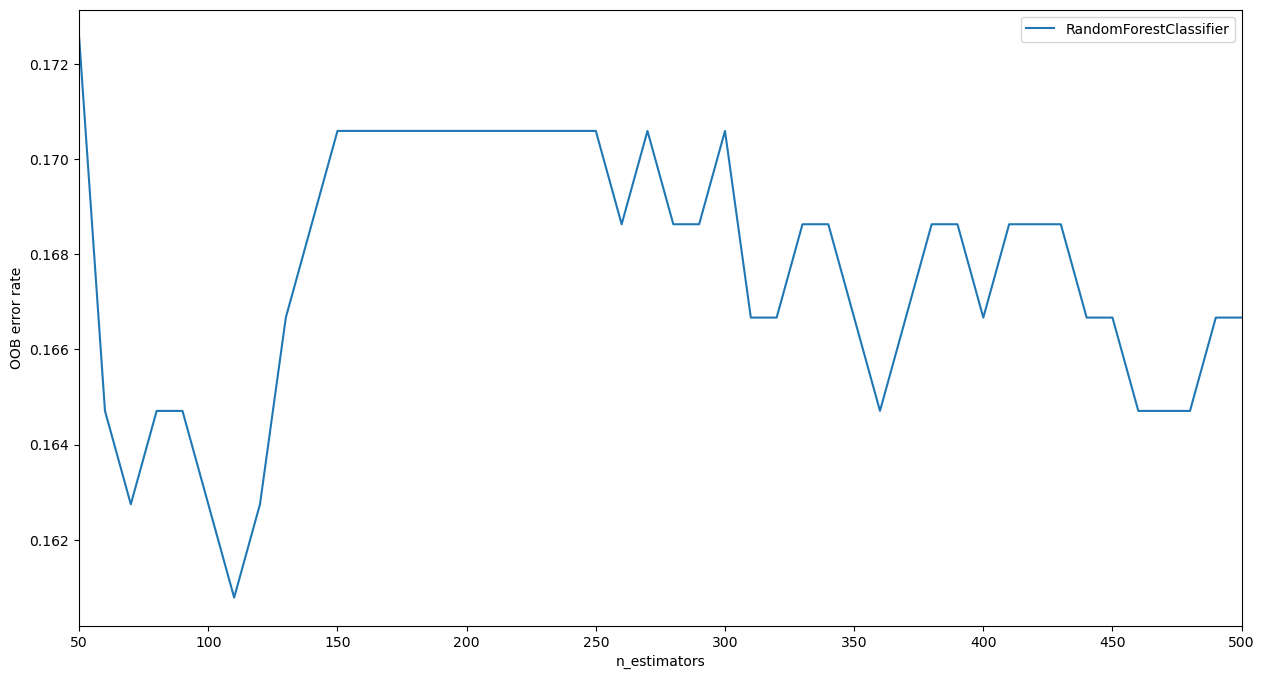

In [27]:
ensemble_rf = [
    ("RandomForestClassifier", RandomForestClassifier(warm_start=True, oob_score=True, random_state=42))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_rf)


min_estimators = 50
max_estimators = 500

for label, rf in ensemble_rf:
    for i in range(min_estimators, max_estimators + 1, 10):
        rf.set_params(n_estimators=i, random_state = 42)
        rf.fit(X, Y)
        oob_error = 1 - rf.oob_score_
        error_rate[label].append((i, oob_error))


for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err) # unzip the tuple with number of trees and OOB error
    plt.figure(figsize=(15,8))
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [28]:
params = {'n_estimators' : [110, 350, 450],
          'criterion' : ['gini', 'entropy'],
          'max_depth' : [None, 4, 10, 15],
          'max_features' : ['sqrt', 'log2', None],
          'bootstrap' : [True, False]}

hyperparameter_tuning = GridSearchCV(RandomForestClassifier(), params, verbose=1, cv=3, n_jobs=-1)

hyp_res = hyperparameter_tuning.fit(X_train, Y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [29]:
hyp_res.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'n_estimators': 110}

In [38]:
# Random Forest
rf = RandomForestClassifier(n_estimators=110, criterion='gini', random_state=42, bootstrap=True, max_depth=10, max_features=None)

# Train the classifier
rf.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_rf = accuracy_score(Y_test, y_pred)
recall_rf = recall_score(Y_test, y_pred, average='micro')
f1_score_rf = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", round(accuracy_rf, 5))
print("Recall:", recall_rf)
print("F1 Score:", f1_score_rf)

Accuracy: 0.92157
Recall: 0.9215686274509803
F1 Score: 0.9215686274509803


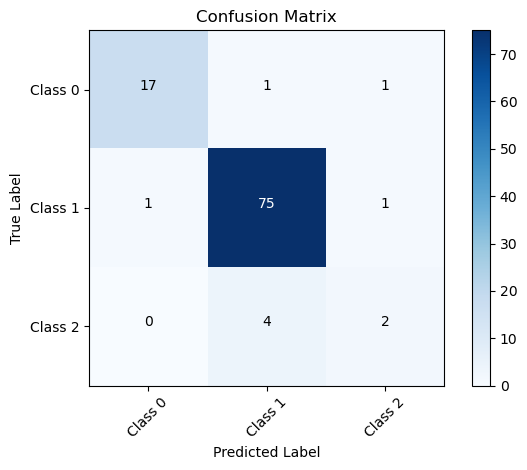

In [39]:
# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels to matrix cells
classes = ['Class 0', 'Class 1', 'Class 2']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add numerical values inside the matrix cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Knn

In [31]:
mean_acc_knn = []

for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i).fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    mean_acc_knn.append(accuracy_score(Y_test, y_pred))

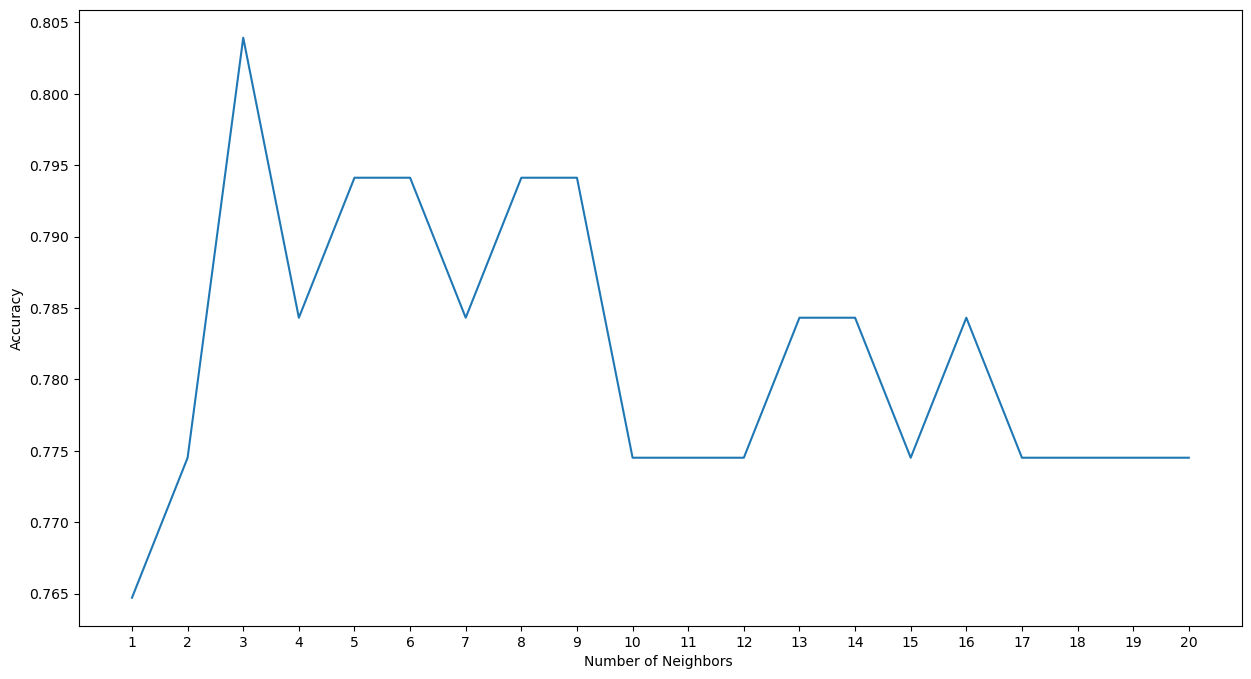

In [32]:
loc = np.arange(1,21,step=1)
plt.figure(figsize = (15, 8))
plt.plot(range(1,21), mean_acc_knn)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [33]:
params = {'n_neighbors' : [3, 5, 9], 
          'weights' : ['uniform', 'distance'],
          'metric' : ['minkowski', 'euclidean', 'manhattan']}

hyperparameter_tuning = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=3, n_jobs=-1)

hyp_res = hyperparameter_tuning.fit(X_train, Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [34]:
hyp_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}

In [35]:
# Create a KNN classifier
k = 9  # number of neighbors
knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', weights='distance')

# Train the classifier
knn.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy of the classifier
accuracy_knn = accuracy_score(Y_test, y_pred)
recall_knn = recall_score(Y_test, y_pred, average='micro')
f1_score_knn = f1_score(Y_test, y_pred, average='micro')
print("Accuracy:", round(accuracy_knn, 5))
print("Recall:", recall_knn)
print("F1 Score:", f1_score_knn)

Accuracy: 0.80392
Recall: 0.803921568627451
F1 Score: 0.8039215686274509


### Dataframe with results

In [36]:
results = pd.DataFrame({'Model Name' : ['Naive Bayes', 'Full Bayes' ,'Decision Tree', 'Random Forest', 'KNN'], 
                                'Accuracy' : [accuracy_nb, accuracy_fb , accuracy_dt, accuracy_rf, accuracy_knn],
                                'Recall' : [recall_nb, recall_fb, recall_dt, recall_rf, recall_knn],
                                'F1 Score' : [f1_score_nb, f1_score_fb, f1_score_dt, f1_score_rf, f1_score_knn]})

In [37]:
results

,Model Name,Accuracy,Recall,F1 Score
0,Naive Bayes,0.539216,0.539216,0.539216
1,Full Bayes,0.754902,0.754902,0.754902
2,Decision Tree,0.882353,0.882353,0.882353
3,Random Forest,0.921569,0.921569,0.921569
4,KNN,0.803922,0.803922,0.803922
